Import libraries

In [2]:
!pip install yellowbrick
!pip install kagglehub

In [3]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Import General library
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt

# Import Data Processing library
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score

# Import Learning Models library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Import Evaluation Metriccs library
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV

import kagglehub

Define basic functions:

In [5]:
def exp_data_analysis(df):
    for col in df.columns[:-1]:
        if df[col].dtype == 'int64':
            for val in unique_classes:
                plt.hist(df[df["income"]==val][col],label=val,alpha=0.7)
            plt.ylabel("No of Adults")
            plt.xlabel(label)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        if df[col].dtype == 'objects':
           df[label].value_counts().plot(kind="bar", figsize=(10,5))
           plt.title(f"{str(label)} distribution")
           plt.xlabel(label)
           plt.ylabel("Count")

        plt.show()

def one_hot_encoder(df, df_ohe, col_names):
    encoder = OneHotEncoder()
    encoded = encoder.fit_transform(df_ohe)

    encoded_df = pd.DataFrame(
    encoded.toarray(),
    columns=encoder.get_feature_names_out(col_names)
    )

    df_combined = pd.concat([df,encoded_df],axis=1)

    return df_combined

def confusion_matrix(model, unique_classes, X_train, y_train, X_test, y_test):
    cm = ConfusionMatrix(model, classes=unique_classes)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    cm.poof()

def class_to_int(y_set):
    int_y_test = y_set.copy()
    int_y_test[int_y_test == ' <=50K'] = '0'
    int_y_test[int_y_test == ' >50K'] = '1'
    int_y_test = int_y_test.astype('int32')

    return int_y_test

def roc_auc_graph(model, unique_classes, X_test, y_test,k,distance):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(unique_classes)

    roc_y_test = class_to_int(y_test)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((roc_y_test == i).astype(int), model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Plot ROC curves
    plt.figure(figsize=(6, 6))
    colors = ['blue', 'red']
    for i, color in enumerate(colors):
        tempclass = " <=50K" if i == 0 else "> 50K"
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {tempclass}) (area = {roc_auc[i]:.4f})')
        if k != "":
          plt.annotate(f'K={k}', xy=(0.8, 0.2), xytext=(0.8, 0.2))
          plt.annotate(f'{distance}', xy=(0.8, 0.16), xytext=(0.8, 0.16))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Display AUC values
    for i in range(n_classes):
        print(f"AUC for class {i}: {roc_auc[i]:.4f}")

    plt.show()

def scale_dataset(dataframe, oversample=False):
  # Extract features from the dataframe: all columns except the last one
  X = dataframe[dataframe.columns[:-1]].values
  # Extract target variable from the dataframe: the last column
  y = dataframe[dataframe.columns[-1]].values
  # Initialize a standard scaler object
  scaler = StandardScaler()
  # Fit the scaler to the data and transform the features to have mean=0 and std deviation=1
  X = scaler.fit_transform(X)

  # Check if oversampling is required
  if oversample:
      # Initialize a random oversampler object for handling class imbalance
      ros = RandomOverSampler()
      # Use the oversampler to balance class distribution by duplicating some minority class samples
      X, y = ros.fit_resample(X, y)

  # Combine the standardized (and optionally oversampled) features and target into one array
  data = np.hstack((X, np.reshape(y, (-1, 1))))

  # Return the combined data, the features, and the target variable
  return data, X, y

def model(x):
      return 1 / (1 + np.exp(-x))



Get the data ready for processing:

In [6]:
pd.set_option('future.no_silent_downcasting', True)

# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

filename = path + '\\adult.csv'
print("Path to dataset files:", filename+'\\adult.csv')

df = pd.read_csv(filename) # add the column name to the dataframe (panda)

df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df.info()

for col in df.select_dtypes('object').columns:
    print(f'----****Value Count of {col}****----\n {df[col].value_counts()}')

df.head()


Path to dataset files: C:\Users\lee20\.cache\kagglehub\datasets\wenruliu\adult-income-dataset\versions\2\adult.csv\adult.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
d

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


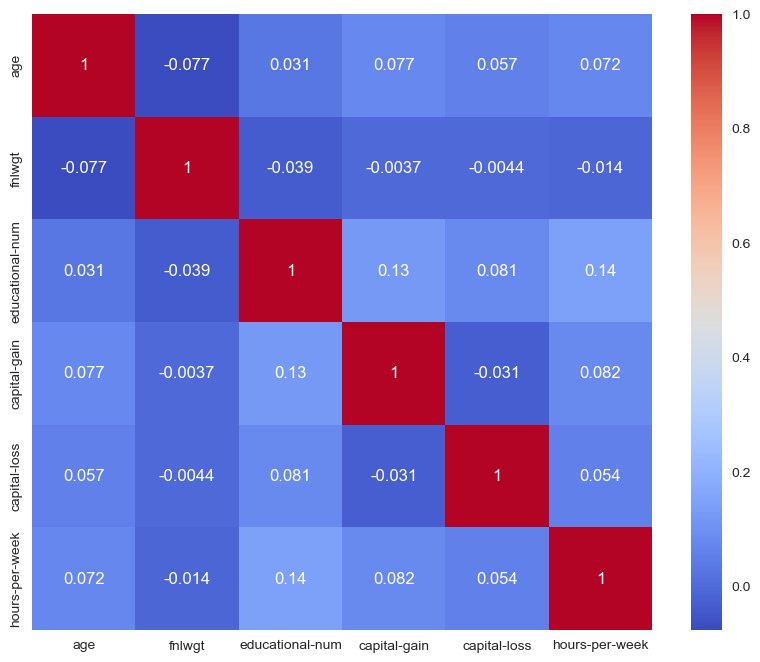

In [7]:
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include='int64')
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [8]:
#df.groupby([col, 'income']).size() → counts number of rows for each unique value of col per income group.
#.reset_index(name='count') → turns the group counts into a DataFrame with columns [col, income, count].
# print(df.groupby(['age', 'income']).size().reset_index(name='count')

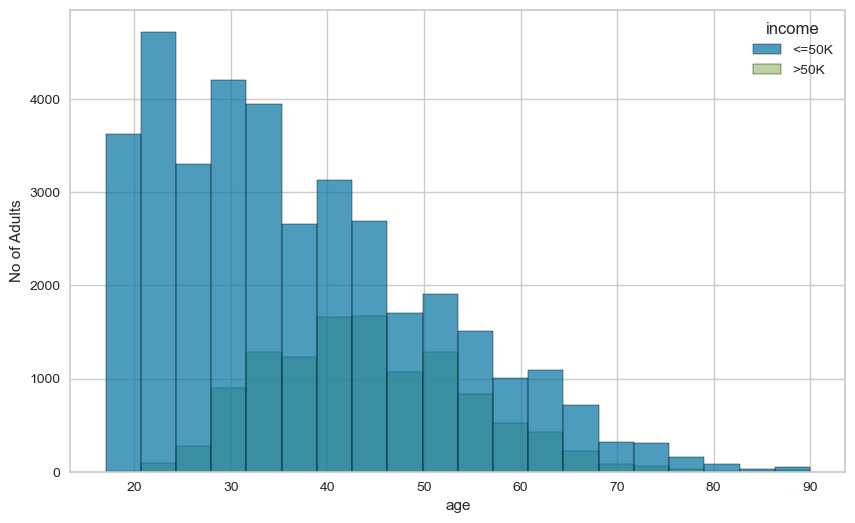

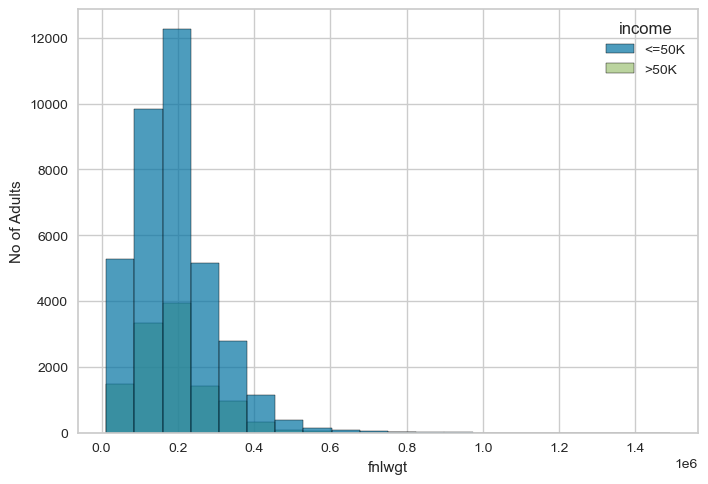

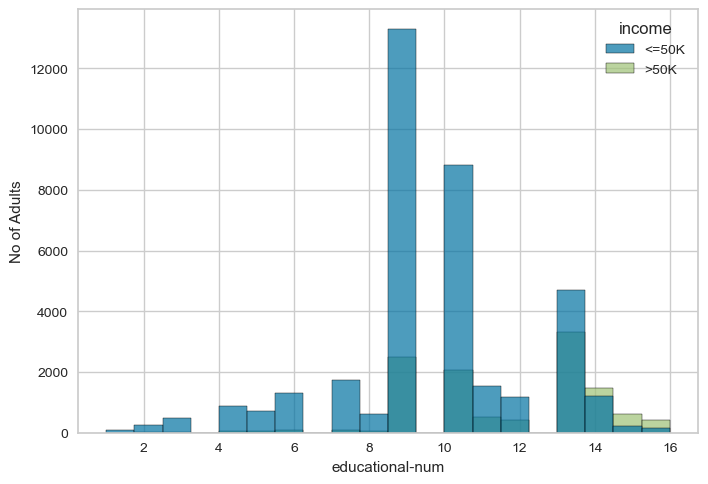

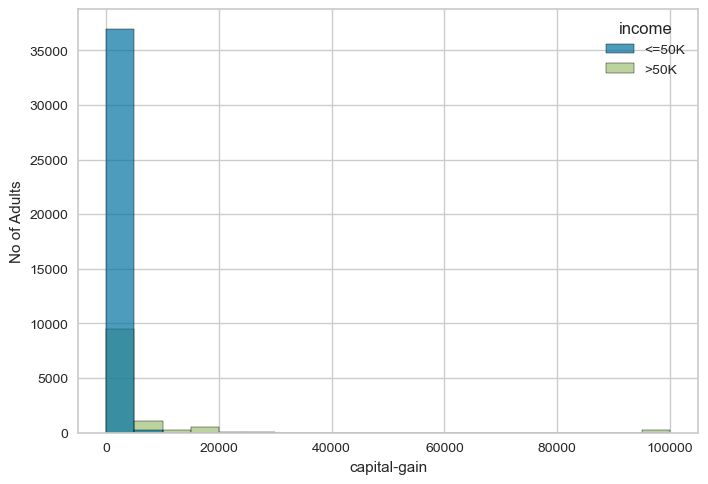

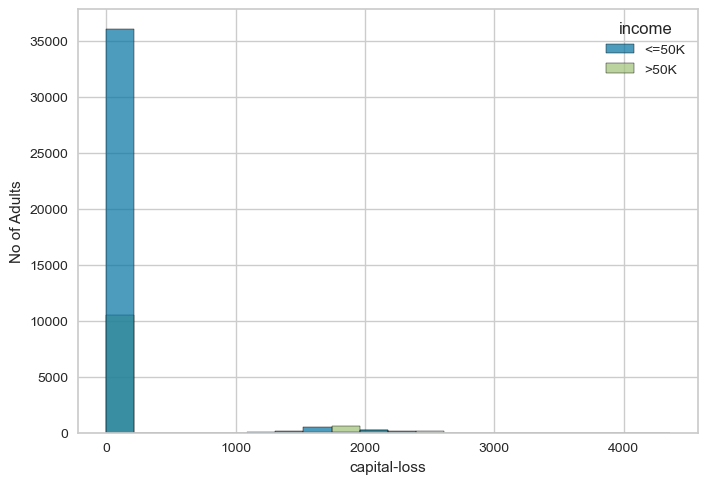

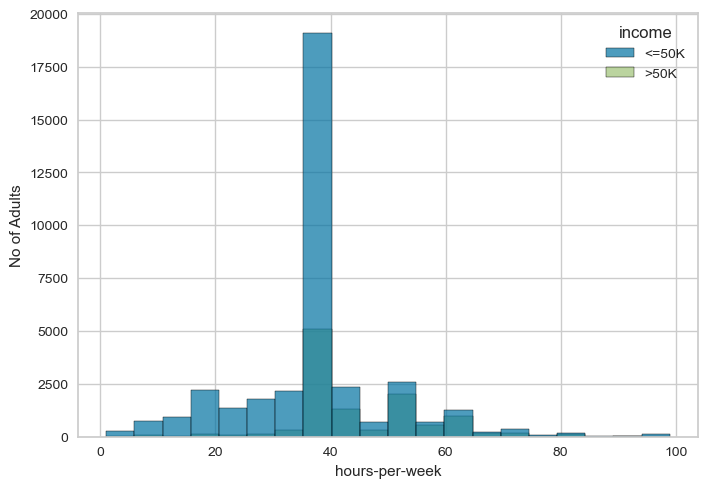

In [9]:
plt.figure(figsize=(10,6))

for col in df.columns[:-1]:
    if df[col].dtype == 'int64':
        ax = sns.histplot(
            df, 
            x=col, 
            hue='income', 
            bins=20, 
            alpha=0.7,  
            #hue_order=['>50K','<=50K'],              # plot 1 first, then 0
            #palette={'<=50K': 'red', '>50K': 'blue'}, # assign colors
        )
        # count_df = df.groupby([col, 'income']).size().reset_index(name='count')
        # sns.lineplot(count_df, x=col, y= 'count', hue = 'income', label=income_grp)
        plt.ylabel("No of Adults")
        plt.xlabel(col)
        #ax.legend(title='income', loc='upper left', bbox_to_anchor=(1, 1))
        #ax.legend(title='Income', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

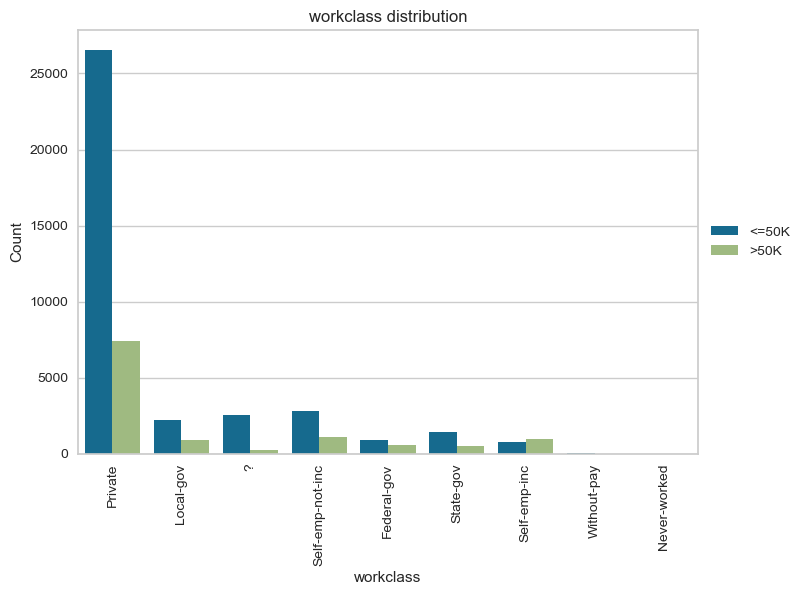

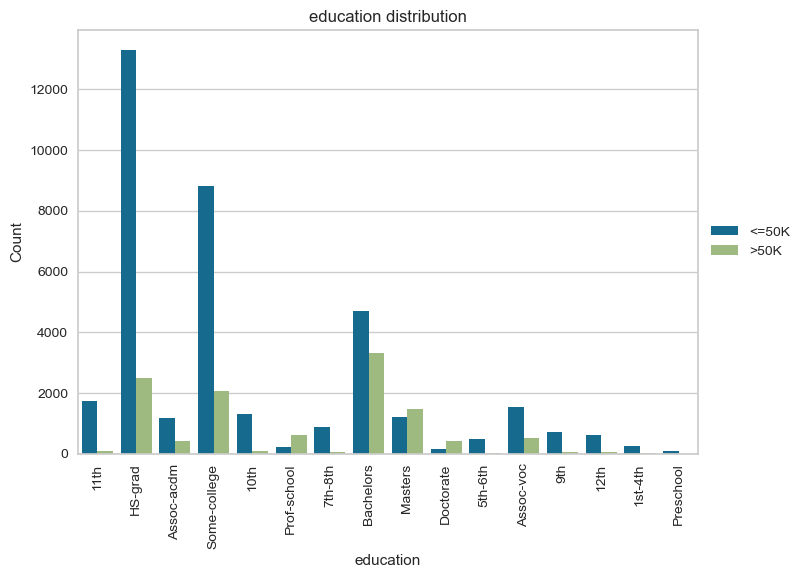

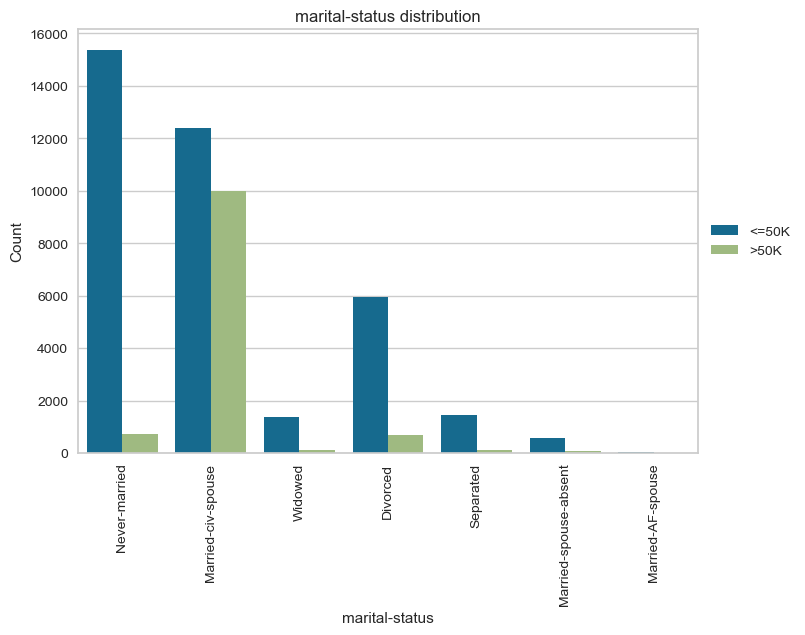

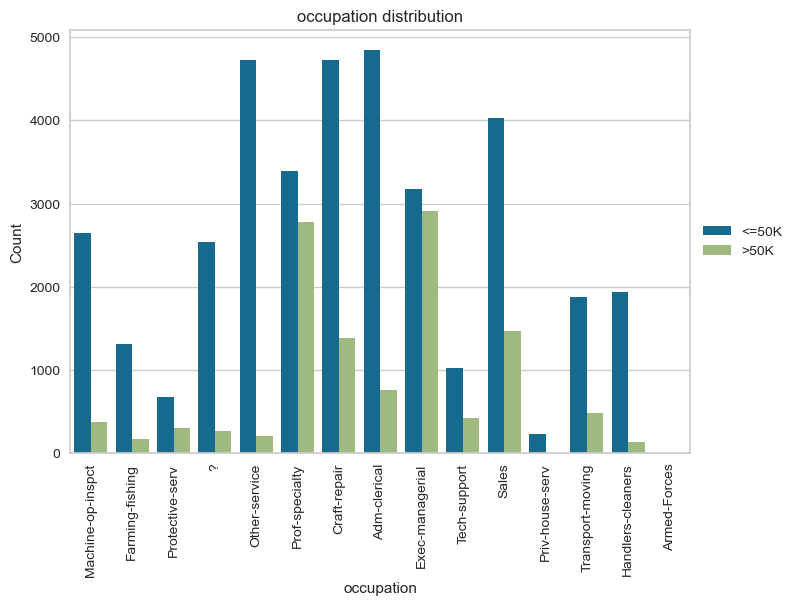

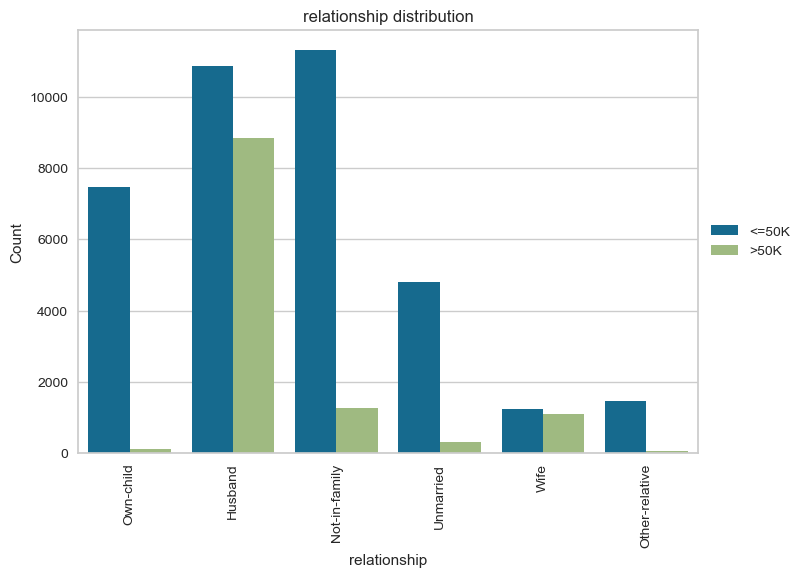

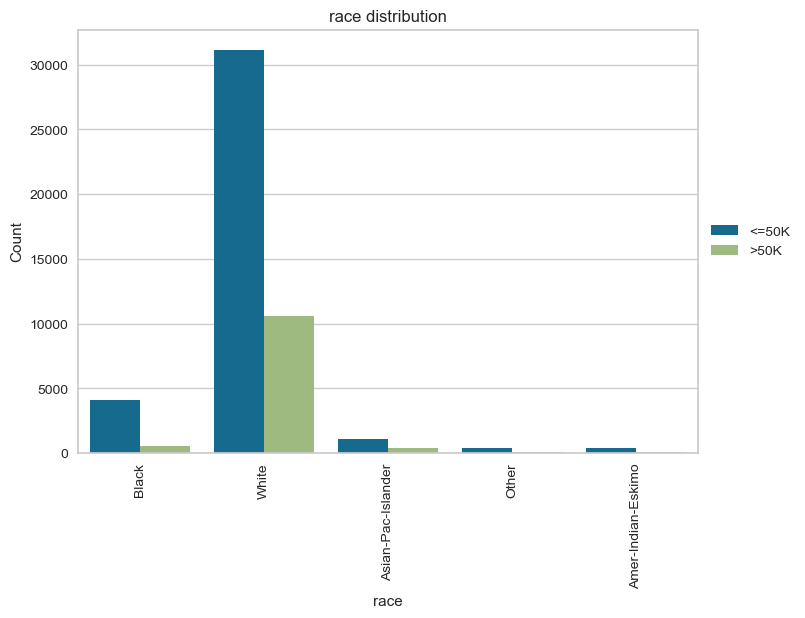

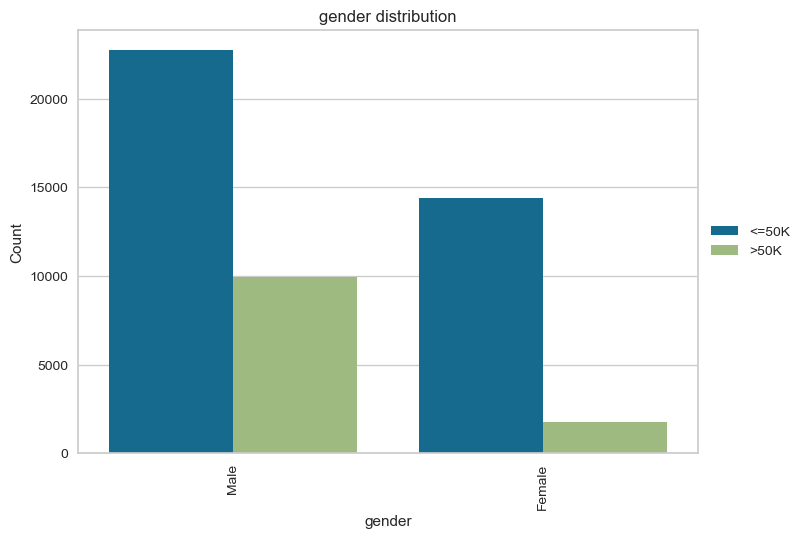

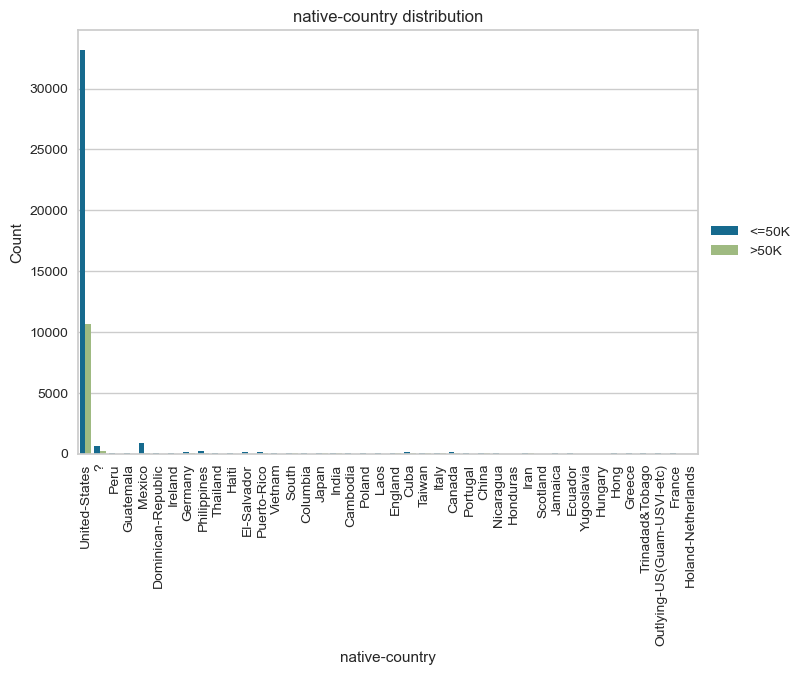

In [10]:
    for col in df.columns[:-1]:
        if df[col].dtype == 'object':
            #counts = df.groupby([col, 'income']).size().unstack(fill_value=0)
            #counts.plot(kind="bar", figsize=(10,5))
            sns.countplot(x=col, hue='income', data=df)
            plt.title(f"{str(col)} distribution")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation=90)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()

In [11]:
#exp_data_analysis(df, cols_format, unique_classes)
ohe_cols = ['workclass','marital-status','occupation','relationship','race']
df_ohe = df[ohe_cols]

ds = one_hot_encoder(df, df_ohe, ohe_cols)
ds.columns = ds.columns.str.replace('-','_')

cols = [col for col in ds.columns if (col not in ['income','fnlwgt'] and '?' not in col)] + ['income']
ds = ds[cols]

le = LabelEncoder()

#Data Processing
#1. Data quality issue. Remove the "." from Income Class.
ds['income'] = le.fit_transform(ds['income'])

#2. Turn the sex into binary field
ds['gender'] = le.fit_transform(df['gender'])

scaler = StandardScaler()
stdcols = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
ds[stdcols] = scaler.fit_transform(ds[stdcols])

#3. Drop the catagorical field that cannot be converted into binary and perform a proper labeling
ds = ds.select_dtypes(exclude='object')

print(f'Rows and Columns:\n{df.shape}')

unique_classes = ds['income'].unique()

ds.head()

Rows and Columns:
(48842, 15)


,age,educational_num,gender,capital_gain,capital_loss,hours_per_week,workclass_Federal_gov,workclass_Local_gov,workclass_Never_worked,workclass_Private,...,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_Amer_Indian_Eskimo,race_Asian_Pac_Islander,race_Black,race_Other,race_White,income
0,-0.995129,7,1,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-0.046942,9,1,-0.144804,-0.217127,0.772930,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,-0.776316,12,1,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.390683,10,1,0.886874,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,-1.505691,10,0,-0.144804,-0.217127,-0.841104,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


Split the data into Training, validating and testing sets.

Over-sampling using SMOTE method:
It works by interpolating between an existing minority class sample and some of its nearest neighbors to create new, synthetic data points.

In [12]:
sqrt_n = mt.floor(mt.sqrt(len(ds))) - 0 if mt.sqrt(len(ds))%2 > 0 else 1

# Split the dataset using ratio according to rule of thumb
# Split the data into training (80%) and the combined validation and test set
train, temp = train_test_split(ds, train_size=0.7, random_state=42)
# Split the combined validation (10%) and test set (10%)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

#Do scaling for the train data only
train, X_train, y_train = scale_dataset(train, oversample=False)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

# Assuming X_train and y_train are your training features and labels
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Shape of training data before SMOTE:", X_train.shape)
print("Shape of training data after SMOTE:", X_train_smote.shape)
print("Class distribution before SMOTE:", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())

Shape of training data before SMOTE: (34189, 46)
Shape of training data after SMOTE: (51844, 46)
Class distribution before SMOTE: 0    25922
1     8267
Name: count, dtype: int64
Class distribution after SMOTE: 0    25922
1    25922
Name: count, dtype: int64


In [13]:
def knn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, k_values, distances):

  for i, k in enumerate(k_values, 1): # return k in: [(1, 1), (2, 5), (3, 20)] #Highest AUC

      for distance in distances:
        # Create a KNN classifier with the current k value
        knn = KNeighborsClassifier(n_neighbors=k,metric=distance) # Help to test manhattan / euclidean
        print("----------------------------------K="f"{k} ------------------------------------------")
        print(f'****************{distance}***********************')
        knn.fit(X_train, y_train)

        # Valiadation data
        cv_scores = cross_val_score(knn, X_train, y_train, cv=5)

        # Evaluate the model on the validation set
        # Calculate and display the accuracy on the test set
        y_valid_pred = knn.predict(X_valid)
        valid_accuracy = accuracy_score(y_valid, y_valid_pred)
        print(f"Validation Set Accuracy:{valid_accuracy:.2f}")

        # Evaluate the model on the test set
        # Calculate and display the accuracy on the test set
        y_test_pred = knn.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Test Set Accuracy: {test_accuracy:.4f}")

        # Print cross-validation scores
        print("Cross-Validation Scores:", cv_scores)
        print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}" )

        # Classification Report for Validation Set
        print("Classification Report for Validation Set:")
        print(classification_report(y_valid, y_valid_pred))

        # Classification Report for Test Set
        print("Classification Report for Test Set:")
        print(classification_report(y_test, y_test_pred))

        #Confusion Matrix
        #==========================================================================
        print(f'****************Cufusion matrix of {k} for Validation Set***********************')
        confusion_matrix(knn,unique_classes,X_train, y_train,X_test, y_test)

        #Compute ROC curve and ROC area for each class
        #==========================================================================
        print(f'****************AUC of {k} for Validation Set***********************')
        roc_auc_graph(knn,unique_classes, X_valid, y_valid,k,distance)

        #Compute ROC curve and ROC area for each class
        #==========================================================================
        print(f'****************AUC of {k} for Testing Set***********************')
        roc_auc_graph(knn,unique_classes, X_test, y_test,k,distance)

def logreg_model(X_train, y_train, X_valid, y_valid, X_test, y_test, logsolver, regtype, c):
    # instantiate the model
    logreg = LogisticRegression(solver=logsolver, random_state=0, penalty = regtype, C = c)

    # fit the model
    logreg.fit(X_train, y_train)

    cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

    y_test_pred = logreg.predict(X_test)

    # Print cross-validation scores
    print("Cross-Validation Scores:", cv_scores)
    print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}" )

    y_valid_pred = logreg.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    print(f"Validation Set Accuracy:{valid_accuracy:.2f}")

    # Classification Report for Validation Set
    print("Classification Report for Validation Set:")
    print(classification_report(y_valid, y_valid_pred))

    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_test_pred)))

    # Classification Report for Test Set
    print("Classification Report for Test Set:")
    print(classification_report(y_test, y_test_pred))

    #Confusion Matrix
    #==========================================================================
    print(f'****************Cufusion matrix of Logistic Regression for Validation Set***********************')
    confusion_matrix(logreg, unique_classes, X_train, y_train, X_test, y_test)

    #Compute ROC curve and ROC area for each class
    #==========================================================================
    print(f'****************AUC of Logistic Regression for Validation Set***********************')
    roc_auc_graph(logreg, unique_classes, X_valid, y_valid,"","")

    #Compute ROC curve and ROC area for each class
    #==========================================================================
    print(f'****************AUC of Logistic Regression for Testing Set***********************')
    roc_auc_graph(logreg, unique_classes, X_test, y_test,"","")

def svm_model(X_train, y_train, X_valid, y_valid, X_test, y_test, krn, reg, gmma):
    scaler = StandardScaler()

    # Fit the scaler on training data and transform it.
    X_train = scaler.fit_transform(X_train)

    # Transform the test data using the same scaler. It's important not to fit again to avoid data leakage.
    X_test = scaler.transform(X_test)

    # SVM Classifier: Support Vector Machine with a linear kernel.
    svm_model = SVC(kernel=krn, C=reg, gamma = gmma)
    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)

    # Calculate the accuracy of the SVM model's predictions.
    svm_accuracy = accuracy_score(y_test, svm_predictions)

    # Generate a detailed classification report showing performance metrics for the SVM.
    svm_classification_report = classification_report(y_test, svm_predictions)

    # Display the SVM's accuracy ,classification report and confusion matrix.
    print("SVM Accuracy:", svm_accuracy)
    print("SVM Classification Report:\n", svm_classification_report)
    confusion_matrix(svm_model, unique_classes, X_train, y_train, X_test, y_test)

def rf_model(X_train, y_train, X_valid, y_valid, X_test, y_test, n_est, rd_state, min_leaf):
    scaler = StandardScaler()

    # Fit the scaler on training data and transform it.
    X_train = scaler.fit_transform(X_train)

    # Transform the test data using the same scaler. It's important not to fit again to avoid data leakage.
    X_test = scaler.transform(X_test)

    # Random Forest Classifier: An ensemble of decision trees.
    rf_model = RandomForestClassifier(n_estimators=n_est, criterion='entropy', random_state=rd_state, max_depth = None)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    # Calculate the accuracy of the Random Forest model's predictions.
    rf_accuracy = accuracy_score(y_test, rf_predictions)

    # Generate a detailed classification report showing performance metrics for the Random Forest.
    rf_classification_report = classification_report(y_test, rf_predictions)

    # Display the Random Forest's accuracy, classification report and confusion matrix.
    print("Random Forest Accuracy:", rf_accuracy)
    print("Random Forest Classification Report:\n", rf_classification_report)
    confusion_matrix(rf_model, unique_classes, X_train, y_train, X_test, y_test)

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'random_state': [42],
    'min_samples_leaf': [5, 10, 15]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)

# Fit GridSearchCV to the oversampled training data
grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding best score
print("Best parameters for Random Forest: ", grid_search.best_params_)
print("Best weighted F1 for Random Forest: ", grid_search.best_score_)

Best parameters for Random Forest:  {'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 42}
Best weighted F1 for Random Forest:  0.8599287932961867


In [15]:
# Define the parameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 137],         # different k values
    #'knn__weights': ['distance'],      # voting method
    'knn__metric': ['euclidean', 'manhattan'],    # distance metric
    'knn__p': [1, 2]                              # 1 = manhattan, 2 = euclidean
}

# Initialize the Random Forest Classifier
knn = KNeighborsClassifier()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1_weighted')

# Fit GridSearchCV to the oversampled training data
grid_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding best score
print("Best parameters for kNN: ", grid_search.best_params_)
print("Best weighted F1 for kNN: ", grid_search.best_score_)

Best parameters for kNN:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__p': 1}
Best weighted F1 for kNN:  0.8569549397110917


In [19]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [10],
    'kernel': ['linear','sigmoid'],
    'gamma': [1, 0.1],     # Kernel coefficient
}

# Initialize the SVM Classifier
svm = SVC()

# Initialize GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=-1)

# Fit GridSearchCV to the oversampled training data
grid_search_svm.fit(X_train_smote, y_train_smote)

# Print the best parameters and the corresponding best score
print("Best parameters for SVM: ", grid_search_svm.best_params_)
print("Best weighted F1 for for SVM: ", grid_search_svm.best_score_)

Best parameters for SVM:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Best weighted F1 for for SVM:  0.8180495302986758


In [20]:
# Pipeline: scale features + logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000))   # increase max_iter for convergence
])

# Hyperparameters to search
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],       # inverse regularization strength
    'logreg__penalty': ['l1', 'l2'],            # L1 (lasso), L2 (ridge)
    'logreg__solver': ['liblinear', 'saga']     # solvers that support l1 and l2
}

# Grid search with weighted F1
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters for LogisticRegression:", grid.best_params_)
print("Best weighted F1 for LogisticRegression:", grid.best_score_)

Best parameters for LogisticRegression: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best weighted F1 for LogisticRegression: 0.8440875588760679


Cross-Validation Scores: [0.82023339 0.81926897 0.82486257 0.81820812 0.8205054 ]
Mean Cross-Validation Accuracy: 0.8206
Validation Set Accuracy:0.81
Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      5642
           1       0.55      0.85      0.67      1684

    accuracy                           0.81      7326
   macro avg       0.75      0.82      0.77      7326
weighted avg       0.86      0.81      0.82      7326

Model accuracy score: 0.8189
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      5591
           1       0.58      0.86      0.69      1736

    accuracy                           0.82      7327
   macro avg       0.76      0.83      0.78      7327
weighted avg       0.86      0.82      0.83      7327

****************Cufusion matrix of Logistic Regression for Validation Set****************

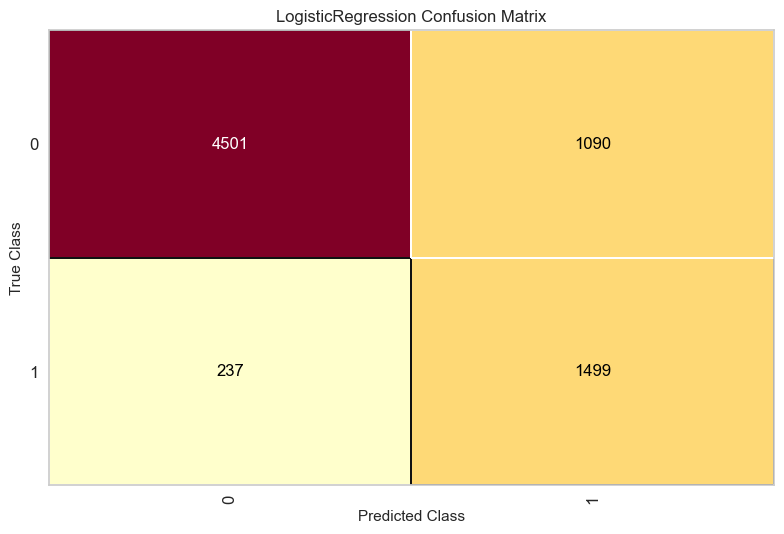

****************AUC of Logistic Regression for Validation Set***********************
AUC for class 0: 0.9050
AUC for class 1: 0.9050


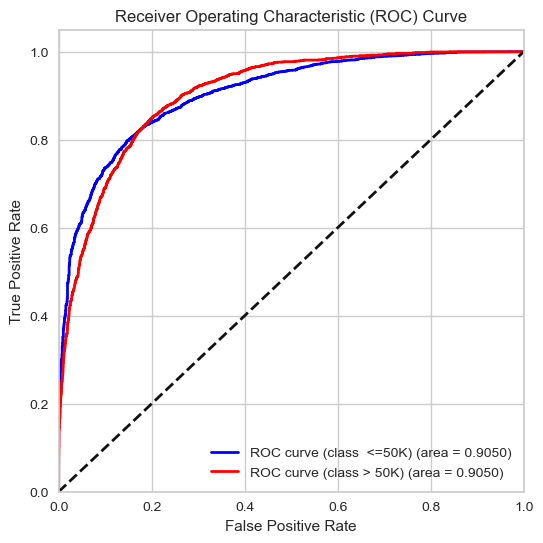

****************AUC of Logistic Regression for Testing Set***********************
AUC for class 0: 0.9138
AUC for class 1: 0.9138


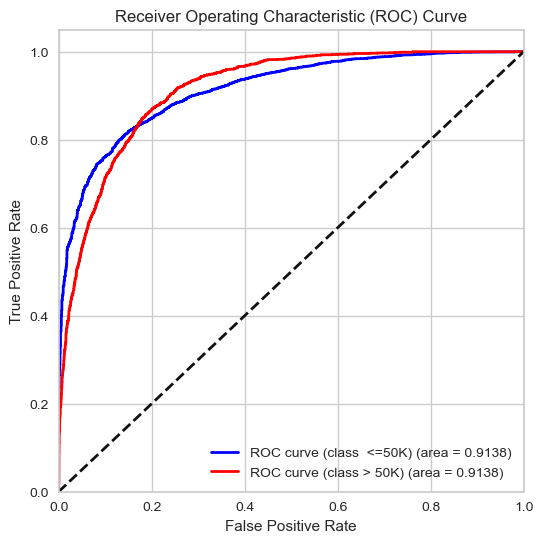

----------------------------------K=3 ------------------------------------------
****************manhattan***********************
Validation Set Accuracy:0.80
Test Set Accuracy: 0.8100
Cross-Validation Scores: [0.84280066 0.84386151 0.86961134 0.8634391  0.87268519]
Mean Cross-Validation Accuracy: 0.8585
Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      5642
           1       0.55      0.69      0.61      1684

    accuracy                           0.80      7326
   macro avg       0.73      0.76      0.74      7326
weighted avg       0.82      0.80      0.81      7326

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      5591
           1       0.58      0.72      0.64      1736

    accuracy                           0.81      7327
   macro avg       0.74      0.78      0.76      7327
weighted avg     

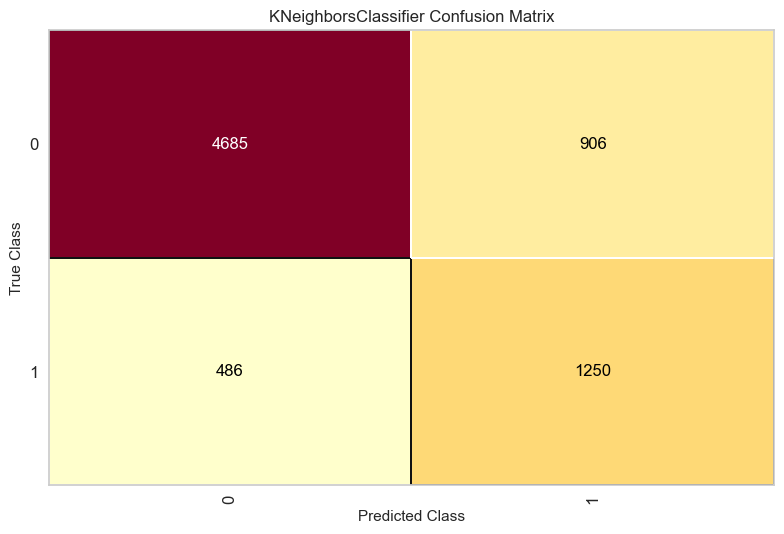

****************AUC of 3 for Validation Set***********************
AUC for class 0: 0.8148
AUC for class 1: 0.8148


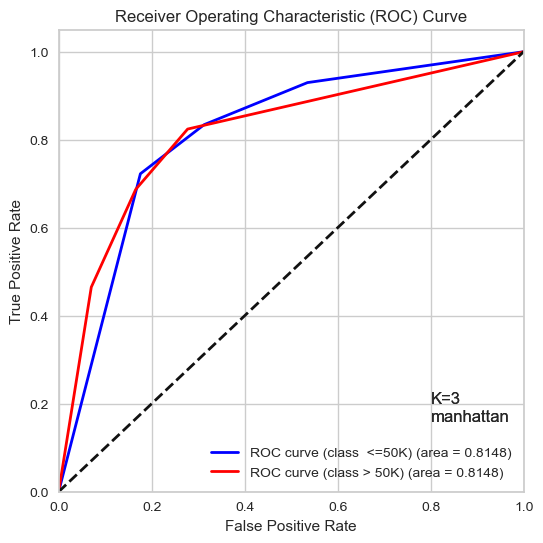

****************AUC of 3 for Testing Set***********************
AUC for class 0: 0.8330
AUC for class 1: 0.8330


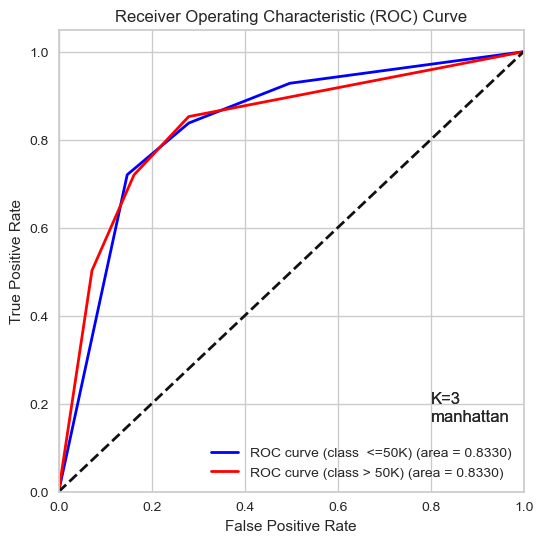

Random Forest Accuracy: 0.49146990582776034
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.35      0.51      5591
           1       0.31      0.95      0.47      1736

    accuracy                           0.49      7327
   macro avg       0.64      0.65      0.49      7327
weighted avg       0.81      0.49      0.50      7327



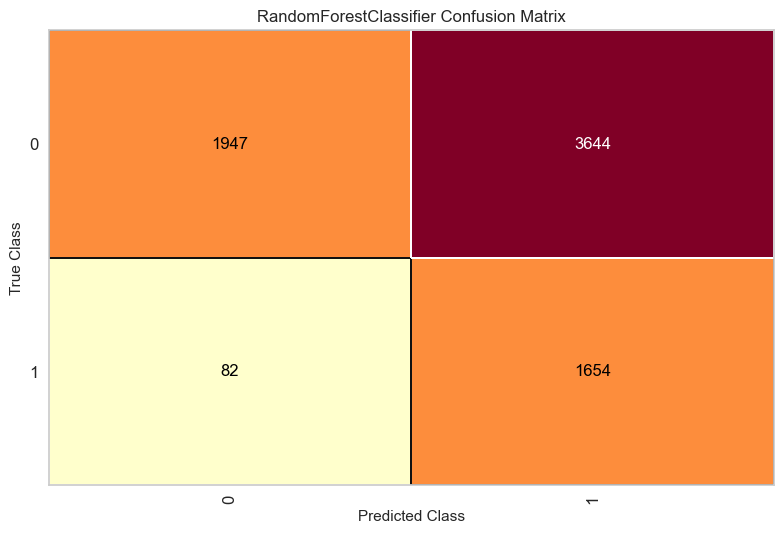

SVM Accuracy: 0.8063327419134707
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86      5591
           1       0.56      0.88      0.68      1736

    accuracy                           0.81      7327
   macro avg       0.76      0.83      0.77      7327
weighted avg       0.86      0.81      0.82      7327



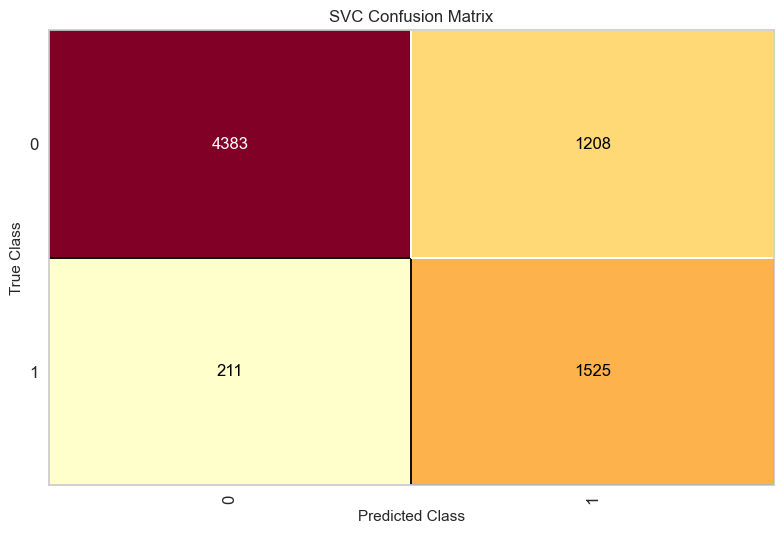

In [21]:
logreg_model(X_train_smote, y_train_smote, X_valid, y_valid, X_test, y_test, logsolver = 'liblinear', regtype = 'l2', c = 0.1)
knn_model(X_train_smote, y_train_smote, X_valid, y_valid, X_test, y_test, k_values = [3], distances = ["manhattan"]) #["euclidean","manhattan","minkowski"]
rf_model(X_train_smote, y_train_smote, X_valid, y_valid, X_test, y_test, n_est = 1000, rd_state = 42, min_leaf =5)
svm_model(X_train_smote, y_train_smote, X_valid, y_valid, X_test, y_test, krn = 'linear', reg = 10, gmma = 1)